# Stratified sampling preparation
This notebook is used to train a deep learning model for stratified sampling.
You have to prepare a dataset with pre-classified images. The directory has the following format:
- **IMG_DIR**
  - **PHENOTYPE1**
    - IMG1
    - IMG2
    - ...
  - **PHENOTYPE2**
    - ...
  - ...

This model will perform the following tasks:

1. Split the dataset into training set and validation set. We have no test case for this task.
2. Train a model to classify all images into different phenotypic groups.
3. Check the model performance.

# Part 1. Split dataset

In [1]:
import os
import re
import random
import pickle as pkl
import pandas as pd
import datetime
from torch.utils.tensorboard import SummaryWriter


def get_next_unique_id(out_dir, date):
    pattern = re.compile(f"^{date}-(\d+)$")
    existing_dirs = os.listdir(out_dir)
    existing_ids = [int(match.group(1)) for dir_name in existing_dirs if (match := pattern.match(dir_name))]
    if existing_ids:
        next_id = max(existing_ids) + 1
    else:
        next_id = 1
    return f"{next_id:03d}"


def create_model_directory(base_dir, classification="classification_models"):
    today = datetime.datetime.now().strftime("%y%m%d")
    classification_models_dir = os.path.join(base_dir, classification)
    os.makedirs(classification_models_dir, exist_ok=True)
    unique_id = get_next_unique_id(classification_models_dir, today)
    model_dir = os.path.join(classification_models_dir, f"{today}-{unique_id}")
    os.makedirs(model_dir, exist_ok=True)
    return model_dir

In [2]:
IMG_DIR = "/home/xavier/Documents/dataset/Welch/classification-v2024/selected_images"  # The images are classified and put in the sub-folders.
OUT_DIR = "/home/xavier/Documents/dataset/Welch/classification-v2024"
MODEL_DIR = create_model_directory(OUT_DIR)  #f"{OUT_DIR}/classification_models/240429-001"  #

classify_df, name_df = [], []
phenotype_dict = {}
'''Build dataset'''
for phenotype in os.listdir(IMG_DIR):
    phenotype_dict[phenotype] = os.listdir(os.path.join(IMG_DIR, phenotype))
    for image_name in os.listdir(os.path.join(IMG_DIR, phenotype)):
        run_id = int(image_name[3:7])
        scope_id = int(image_name[13:14]) if image_name[14] == "-" else int(image_name[13:15])
        frame_id = int(image_name[-8:-4])
        name_df.append((run_id, scope_id, phenotype, image_name))
        if frame_id != 1:
            classify_df.append((run_id, scope_id, image_name))

classify_df = pd.DataFrame(classify_df, columns=['run_id', 'scope_id', 'name'])
classify_df = classify_df[['run_id', 'scope_id']].drop_duplicates()
name_df = pd.DataFrame(name_df, columns=['run_id', 'scope_id', 'phenotype', 'name'])
name_df.to_csv(f'{MODEL_DIR}/details.csv', index=False)
name_df

,run_id,scope_id,phenotype,name
0,669,18,Dense,Run0669_scope18-00_1081.jpg
1,588,4,Dense,Run0588_scope4-00_1441.jpg
2,607,37,Dense,Run0607_scope37-00_1441.jpg
3,296,5,Dense,Run0296_scope5-00_1241.jpg
4,405,23,Dense,Run0405_scope23-00_1241.jpg
...,...,...,...,...
2924,294,40,LWT,Run0294_scope40-00_1441.jpg
2925,331,71,LWT,Run0331_scope71-00_1441.jpg
2926,728,10,LWT,Run0728_scope10-00_1441.jpg
2927,408,34,LWT,Run0408_scope34-00_1441.jpg


## Add more images

In [3]:
'''Get end frames'''
# import shutil
# 
# DATASET_DIR = "/home/xavier/Documents/dataset/Welch/trainingset2/trainingset2"
# EXTRA_DIR = "/home/xavier/Documents/dataset/Welch/trainingset2-1400-grp/phenotypes-new/version2024/selected_images"
# collected_names = name_df['name'].tolist()
# name_phenotype = {}
# for idx, row in name_df.iterrows():
#     name_phenotype[row['name']] = row['phenotype']
# for phenotype in name_df['phenotype'].unique():
#     os.makedirs(os.path.join(EXTRA_DIR, phenotype), exist_ok=True)
# 
# for experiment in os.listdir(DATASET_DIR):
#     run_id = int(experiment[-4:])
#     for subdir in os.listdir(os.path.join(DATASET_DIR, experiment)):
#         scope_id = int(subdir[-2:])
#         name_format = os.listdir(os.path.join(DATASET_DIR, experiment, subdir))[0][:-8] + "%04d.jpg"
#         img_name1 = name_format % 1
#         img_name2 = name_format % 1400
#         if img_name1 in collected_names:
#             shutil.copy(os.path.join(DATASET_DIR, experiment, subdir, img_name1),
#                         os.path.join(EXTRA_DIR, name_phenotype[img_name1], img_name1))
#         if img_name2 in collected_names:
#             for i in range(1441, 0, -1):
#                 if os.path.exists(os.path.join(DATASET_DIR, experiment, subdir, name_format % i)):
#                     shutil.copy(os.path.join(DATASET_DIR, experiment, subdir, name_format % i),
#                                 os.path.join(EXTRA_DIR, name_phenotype[img_name2], name_format % i))
#                     break
'''Get earlier frames'''
# ROOT_DIR = "/home/xavier/Documents/dataset/Welch/trainingset2/trainingset2"
# APPENDIX_DIR = "/home/xavier/Documents/dataset/Welch/trainingset2-1400-grp/phenotypes-new/version2024/appendix"
# os.makedirs(APPENDIX_DIR, exist_ok=True)
# for strain in os.listdir(ROOT_DIR):
#     run_id = int(strain[-4:])
#     for scope in os.listdir(os.path.join(ROOT_DIR, strain)):
#         scope_id = int(scope[-2:])
#         name_format = os.listdir(os.path.join(ROOT_DIR, strain, scope))[0][:-8] + "%04d.jpg"
#         filtered_df = classify_df[(classify_df["run_id"] == run_id) & (classify_df["scope_id"] == scope_id)]
#         phenotype = filtered_df["phenotype"].iloc[0]
#         target_dir = f"{APPENDIX_DIR}/{phenotype}"
#         os.makedirs(target_dir, exist_ok=True)
#         for frame in [1081, 1241]:
#             try:
#                 # os.remove(os.path.join(IMG_DIR, phenotype, name_format % frame))
#                 shutil.copy(os.path.join(ROOT_DIR, strain, scope, name_format % frame),
#                             os.path.join(IMG_DIR, phenotype, name_format % frame))
#             except:
#                 print(1)

'Get earlier frames'

## Select validation set
We choose 1/5 images for validation set. The movies have distinct run_id.

In [6]:
VALIDATION_SIZE = len(classify_df) // 5
print(f"{VALIDATION_SIZE} validation frames")
unique_run_ids = classify_df['run_id'].drop_duplicates().sample(n=VALIDATION_SIZE, random_state=520)
validation_set = classify_df[classify_df['run_id'].isin(unique_run_ids)].groupby('run_id').apply(
    lambda x: x.sample(1, random_state=1314)).reset_index(drop=True)

mask = pd.merge(classify_df, validation_set, on=['run_id', 'scope_id'], how='left', indicator=True)
training_set = mask[mask['_merge'] == 'left_only'].drop(columns=['_merge'])

validation_set['Category'] = 'Validation'
training_set['Category'] = 'Training'
full_dataset = pd.concat([validation_set, training_set])
full_dataset = full_dataset.drop_duplicates(subset=['run_id', 'scope_id'])
full_dataset = full_dataset[['run_id', 'scope_id', 'Category']]
full_dataset.to_csv(f'{MODEL_DIR}/classifier_full_dataset.csv', index=False)

full_dataset

187 validation frames


,run_id,scope_id,Category
0,223,39,Validation
1,225,45,Validation
2,226,26,Validation
3,227,29,Validation
4,228,32,Validation
...,...,...,...
932,586,22,Training
933,641,5,Training
934,620,18,Training
935,569,15,Training


## Load dataset

In [7]:
loaded_dataset = pd.read_csv(f'{MODEL_DIR}/classifier_full_dataset.csv')
name_df = pd.read_csv(f'{MODEL_DIR}/details.csv')
validation_df = loaded_dataset[loaded_dataset['Category'] == 'Validation'].drop('Category', axis=1)
training_df = loaded_dataset[loaded_dataset['Category'] == 'Training'].drop('Category', axis=1)
validation_df = pd.merge(validation_df, name_df, how='inner', on=['run_id', 'scope_id'])
training_df = pd.merge(training_df, name_df, how='inner', on=['run_id', 'scope_id'])

phenotype_counts = validation_df['phenotype'].value_counts()
total_count = validation_df.shape[0]
validation_df['weight'] = validation_df['phenotype'].apply(lambda x: phenotype_counts[x] / total_count)

print(
    f"Training set has {len(training_df['phenotype'].unique())} phenotypes, validation set has {len(validation_df['phenotype'].unique())} phenotypes.")

trainingset_labels = {}
for phenotype, group in training_df.groupby('phenotype'):
    names = group['name'].values
    trainingset_labels[phenotype] = [f"{phenotype}/{name}" for name in names]
pkl.dump(trainingset_labels, open(os.path.join(MODEL_DIR, "trainingset_labels.pkl"), "wb"))

counts_df1 = training_df['phenotype'].value_counts().rename('Training set')
counts_df2 = validation_df['phenotype'].value_counts().rename('Validation set')

counts_df1 = counts_df1.reset_index().rename(columns={'index': 'phenotype'})
counts_df2 = counts_df2.reset_index().rename(columns={'index': 'phenotype'})

merged_counts = pd.merge(counts_df1, counts_df2, on='phenotype', how='outer').fillna(0)
merged_counts[['Training set', 'Validation set']] = merged_counts[
    ['Training set', 'Validation set']].astype(
    int)
merged_counts = merged_counts.sort_values('phenotype')

total_row = merged_counts[['Training set', 'Validation set']].sum().astype(int)
total_row.name = 'Total'

total_df = pd.DataFrame(total_row).transpose()
merged_counts = pd.concat([merged_counts, total_df])
merged_counts['Total'] = merged_counts[['Training set', 'Validation set']].sum(axis=1).astype(int)

merged_counts

Training set has 13 phenotypes, validation set has 13 phenotypes.


,phenotype,Training set,Validation set,Total
7,Blank,99,25,124
12,Branched,9,3,12
9,Clusters,51,18,69
3,Dense,162,45,207
2,Incomplete,432,93,525
0,LWT,552,93,645
11,Large,15,18,33
10,Long,36,12,48
4,Malformed,156,21,177
8,Small,96,24,120


# Part 2: Train a classification model
We use transfer learning with a pre-trained inception-v3 network.
## Helper functions

In [8]:
import cv2
import math
import copy
import numpy as np
import click
import dnnlib
import pickle as pkl
import torch
import torch.nn as nn
import torch.optim as optim
from torch_utils import misc
from torch.utils.data import DataLoader, Dataset
from sklearn.metrics import accuracy_score, balanced_accuracy_score
from sklearn.utils.class_weight import compute_class_weight
from torchvision import transforms


class EarlyStopping:
    def __init__(self, patience=7, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_loss = float('inf')
        self.early_stop = False

    def __call__(self, val_loss):
        if val_loss < self.best_loss - self.min_delta:
            self.best_loss = val_loss
            self.counter = 0
        else:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True


def init_dataset_kwargs(data, label_dict, normalize=False, norm_min=0, norm_max=1, resolution=512, resize_by=1.):
    try:
        dataset_kwargs = dnnlib.EasyDict(class_name='dataloaders.PairedMyxo.PairedMyxo', resolution=resolution,
                                         resize_by=resize_by, num_output=1,
                                         path=data, use_labels=True, max_size=None, xflip=False, use_rgb=True,
                                         normalize=normalize, norm_min=norm_min, norm_max=norm_max,
                                         mode="random", label_dict=label_dict)
        dataset_obj = dnnlib.util.construct_class_by_name(**dataset_kwargs)  # Subclass of training.dataset.Dataset.
        dataset_kwargs.resolution = dataset_obj.resolution  # Be explicit about resolution.
        dataset_kwargs.use_labels = dataset_obj.has_labels  # Be explicit about labels.
        dataset_kwargs.max_size = len(dataset_obj)  # Be explicit about dataset size.
        return dataset_kwargs, dataset_obj.name
    except IOError as err:
        raise click.ClickException(f'--data: {err}')


def encode_labels(labels, label_dict):
    return [label_dict[label] for label in labels]


def count_parameters(model):
    tot_parameters = 0
    trainable_parameters = 0
    for p in model.parameters():
        tot_parameters += p.numel()
        if p.requires_grad:
            trainable_parameters += p.numel()
    print(f'Total number of parameters: {tot_parameters}, Trainable parameters: {trainable_parameters}')


def validate(model, criterion, balanced_criterion, dataloader, device):
    model.eval()  # Set model to evaluate mode
    val_losses = []
    val_bal_losses = []
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_losses.append(loss.item())
            bal_loss = balanced_criterion(outputs, labels)
            val_bal_losses.append(bal_loss.item())

            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    model.train()  # Set model back to train mode

    avg_loss = np.mean(val_losses)
    bal_loss = np.mean(val_bal_losses)

    accuracy = accuracy_score(all_labels, all_preds)
    bal_accuracy = balanced_accuracy_score(all_labels, all_preds)
    return avg_loss, bal_loss, accuracy, bal_accuracy


def accuracy(outputs, all_labels):
    _, preds = torch.max(outputs, 1)
    accuracy = accuracy_score(all_labels, preds)
    bal_accuracy = balanced_accuracy_score(all_labels, preds)
    return accuracy, bal_accuracy


def delete_old_models(current_epoch, model_dir, keep_last_n=200):
    oldest_epoch_to_keep = current_epoch - keep_last_n

    for filename in os.listdir(model_dir):
        if filename.startswith("model_epoch_"):
            epoch_num = int(filename.split('_')[2].split('.')[0])

            if epoch_num <= oldest_epoch_to_keep:
                os.remove(os.path.join(model_dir, filename))
                print(f"Deleted old model: {filename}")


def resize_crop(img_dir, resize_by=1., resolution=512, brightness_norm=False, brightness_mean=107.2,
                use_rgb=True,
                method="random",
                crop_features=None,
                normalize=False, norm_min=0, norm_max=1):
    img = cv2.imread(img_dir, cv2.IMREAD_UNCHANGED)
    if img.dtype != np.uint8:
        img = np.uint8(img / 256)
    img_shape = img.shape
    resize_shape = np.array([img_shape[1] * resize_by, img_shape[0] * resize_by], dtype=int)
    if resize_by != 1:
        img = cv2.resize(img, resize_shape, cv2.INTER_LANCZOS4)

    crop_diag = np.sqrt(np.square(resolution) * 2)
    if use_rgb and len(img.shape) == 2:
        img = cv2.cvtColor(img, cv2.COLOR_GRAY2BGR)
    if method == "random":
        angle = crop_features[0]
        new_len = np.max([abs(crop_diag * np.cos((angle + 45) / 180 * np.pi)),
                          abs(crop_diag * np.sin((angle + 45) / 180 * np.pi))])
        new_len = int(math.ceil(new_len))
        x_sample = crop_features[1]
        y_sample = crop_features[2]

        x_min = min([x_sample, 0])
        y_min = min([y_sample, 0])

        cropped_img = img[x_min:x_min + new_len, y_min:y_min + new_len]
        # Vertical flip
        if crop_features[3]:
            cropped_img = cropped_img[::-1, :]
        # Compute rotation matrix
        h, w = cropped_img.shape[:2]
        cropped_center = (w // 2, h // 2)
        rotation_matrix = cv2.getRotationMatrix2D(cropped_center, angle, 1)
        # Rotate the image
        rot_img = cv2.warpAffine(cropped_img, rotation_matrix, (w, h))
        rot_img_shape = rot_img.shape
        img_center = [rot_img_shape[0] // 2, rot_img_shape[1] // 2]
        new_img = rot_img[img_center[0] - resolution // 2:img_center[0] + resolution // 2,
                  img_center[1] - resolution // 2:img_center[1] + resolution // 2]
    else:
        new_img = img[(resize_shape[1] - resolution) // 2:(resize_shape[1] + resolution) // 2,
                  (resize_shape[0] - resolution) // 2:(resize_shape[0] + resolution) // 2]
    if brightness_norm:
        obj_v = np.mean(new_img)
        value = brightness_mean - obj_v
        new_img = cv2.add(new_img, value)
    if normalize:
        new_img = new_img / (255 / (norm_max - norm_min)) + norm_min
    return new_img


def get_resize_features(img_dir, resize_by=1., resolution=512, copies=10):
    img = cv2.imread(img_dir, cv2.IMREAD_UNCHANGED)
    if img.dtype != np.uint8:
        img = np.uint8(img / 256)
    img_shape = img.shape
    resize_shape = np.array([img_shape[1] * resize_by, img_shape[0] * resize_by], dtype=int)
    if resize_by != 1:
        img = cv2.resize(img, resize_shape, cv2.INTER_LANCZOS4)
    img_shape = img.shape
    crop_diag = np.sqrt(np.square(resolution) * 2)

    crop_features = []
    for i in range(copies):
        angle = np.random.uniform(-180, 180)
        new_len = np.max([abs(crop_diag * np.cos((angle + 45) / 180 * np.pi)),
                          abs(crop_diag * np.sin((angle + 45) / 180 * np.pi))])
        new_len = int(math.ceil(new_len))
        x_sample = np.random.randint(new_len // 2, img_shape[0] - np.ceil(new_len / 2))
        y_sample = np.random.randint(new_len // 2, img_shape[1] - np.ceil(new_len / 2))
        # Vertical flip
        is_flip = random.random() > 0.5
        crop_features.append((angle, x_sample, y_sample, is_flip))
    return crop_features

## Set parameters

In [10]:
EPOCHS = 1000000
BATCH_SIZE = 600
VAL_EPOCH = 10
num_gpus = 1
TRAINING_WORKERS = 4
VALIDATION_WORKERS = 4
EARLYSTOP_PATIENCE = 10
resume = None
os.makedirs(MODEL_DIR, exist_ok=True)
device = torch.device('cuda')

label_dict = {phenotype: i for i, phenotype in enumerate(trainingset_labels)}

pkl.dump(label_dict, open(f"{MODEL_DIR}/phenotype_index.pkl", "wb"))

print("The model will be saved in {}".format(MODEL_DIR))

The model will be saved in /home/xavier/Documents/dataset/Welch/classification-v2024/classification_models/240529-003


## Construct validation set

In [11]:
class ValidationDataset(Dataset):
    def __init__(self, validation_df, copies=10, preload=False, data_dir=None, method="random", normalize=False,
                 norm_min=0, norm_max=1,
                 dtype=torch.int, resolution=512, resize_by=1.):
        self.normalize = normalize
        self.norm_min = norm_min
        self.norm_max = norm_max
        self.dtype = dtype
        self.method = method
        self.resolution = resolution
        self.resize_by = resize_by
        if preload and data_dir:
            data = pkl.load(open(data_dir, "rb"))
            self.validation_inputs = data['validation_inputs']
            self.validation_crop_features = data['validation_crop_features']
            self.validation_labels = data['validation_labels']
        else:
            self.validation_inputs = []
            self.validation_crop_features = []
            self.validation_labels = []
            for index, row in validation_df.iterrows():
                img_name = f"{IMG_DIR}/{row['phenotype']}/{row['name']}"
                self.validation_inputs.append(img_name)
                self.validation_crop_features.append(
                    get_resize_features(img_name, copies=copies, resolution=resolution, resize_by=resize_by))
                self.validation_labels.append(row['phenotype'])

    def save(self, file_path):
        with open(file_path, 'wb') as f:
            data = {
                'validation_inputs': self.validation_inputs,
                'validation_crop_features': self.validation_crop_features,
                'validation_labels': self.validation_labels
            }
            pkl.dump(data, f)

    def __len__(self):
        return len(self.validation_inputs) * 10

    def __getitem__(self, idx):
        ten = idx // 10
        res = idx % 10
        if self.method == "random":
            img = resize_crop(self.validation_inputs[ten], crop_features=self.validation_crop_features[ten][res],
                              resolution=self.resolution, resize_by=self.resize_by,
                              method=self.method, normalize=self.normalize, norm_min=self.norm_min,
                              norm_max=self.norm_max)
        else:
            img = resize_crop(self.validation_inputs[ten], resolution=self.resolution, resize_by=self.resize_by,
                              method=self.method, normalize=self.normalize, norm_min=self.norm_min,
                              norm_max=self.norm_max)
        label = self.validation_labels[ten]
        img = torch.tensor(img[:, :, :], dtype=self.dtype).permute(2, 0, 1)
        label = torch.tensor(label_dict[label])
        return img, label

## Model Initialization

In [12]:
'''Load pre-trained model'''
MODEL_INPUT_DTYPE = torch.int
MODEL_INPUT_RESOLUTION = 512
MODEL_NORMALIZE = False
MODEL_RESIZE_BY = 1.
MODEL_NORM_MIN = 0
MODEL_NORM_MAX = 1
detector_url = 'https://api.ngc.nvidia.com/v2/models/nvidia/research/stylegan3/versions/1/files/metrics/inception-2015-12-05.pkl'
if resume:
    with dnnlib.util.open_url(resume, verbose=True) as f:
        detector = pkl.load(f)
else:
    with dnnlib.util.open_url(detector_url, verbose=True) as f:
        detector = pkl.load(f)
    detector.output = nn.Linear(2048, len(trainingset_labels))

detector.output.requires_grad_(True).train()
detector = detector.to(device)

optimizer = optim.Adam(detector.parameters())

count_parameters(detector)

Total number of parameters: 21829421, Trainable parameters: 26637


In [13]:
# import torchvision.models as models
# from torchvision.models import ResNet50_Weights
# 
# MODEL_INPUT_DTYPE = torch.float
# MODEL_INPUT_RESOLUTION = 224
# MODEL_NORMALIZE = True
# MODEL_RESIZE_BY = .5
# MODEL_NORM_MIN = 0
# MODEL_NORM_MAX = 1
# 
# weights = ResNet50_Weights.DEFAULT
# detector = models.resnet50(weights=weights)
# for param in detector.parameters():
#     param.requires_grad = False
# num_features = detector.fc.in_features
# detector.fc = nn.Linear(num_features, len(trainingset_labels))
# 
# detector = detector.to(device)
# optimizer = optim.Adam(detector.parameters())
# 
# count_parameters(detector)

## Training set

In [14]:
training_set_kwargs, dataset_name = init_dataset_kwargs(
    data=IMG_DIR,
    label_dict=f"{MODEL_DIR}/trainingset_labels.pkl",
    normalize=MODEL_NORMALIZE,
    norm_min=MODEL_NORM_MIN,
    norm_max=MODEL_NORM_MAX, resolution=MODEL_INPUT_RESOLUTION, resize_by=MODEL_RESIZE_BY)
data_loader_kwargs = dnnlib.EasyDict(pin_memory=True, prefetch_factor=1)
data_loader_kwargs.num_workers = TRAINING_WORKERS
training_set_loader = dnnlib.util.construct_class_by_name(**training_set_kwargs)
training_set_sampler = misc.InfiniteSampler(dataset=training_set_loader, rank=0, num_replicas=1, seed=123)
training_set_iterator = iter(
    torch.utils.data.DataLoader(dataset=training_set_loader, sampler=training_set_sampler,
                                batch_size=BATCH_SIZE // num_gpus, **data_loader_kwargs))
print("Training set size: ", len(training_set_loader), " (before data augmentation)")

/home/xavier/anaconda3/envs/st3-pure/lib/python3.9/site-packages/torch/utils/data/sampler.py:64: UserWarning: `data_source` argument is not used and will be removed in 2.2.0.You may still have custom implementation that utilizes it.
  warnings.warn("`data_source` argument is not used and will be removed in 2.2.0."


Training set size:  2343  (before data augmentation)


## Validation set

In [15]:
validation_dataset = ValidationDataset(validation_df, method="random", dtype=MODEL_INPUT_DTYPE,
                                       normalize=MODEL_NORMALIZE, resize_by=MODEL_RESIZE_BY, norm_min=MODEL_NORM_MIN,
                                       norm_max=MODEL_NORM_MAX)
validation_dataset.save(f"{MODEL_DIR}/validationset_parameters.pkl")

In [16]:
label_dict = pkl.load(open(f"{MODEL_DIR}/phenotype_index.pkl", "rb"))
validation_dataset = ValidationDataset(validation_df, preload=True,
                                       data_dir=f"{MODEL_DIR}/validationset_parameters.pkl",
                                       method="random", dtype=MODEL_INPUT_DTYPE, normalize=MODEL_NORMALIZE,
                                       resize_by=MODEL_RESIZE_BY, norm_min=MODEL_NORM_MIN, norm_max=MODEL_NORM_MAX)
validation_loader = DataLoader(validation_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=VALIDATION_WORKERS)

# Assuming 'all_labels' contains all the labels in your training dataset
class_weights = compute_class_weight('balanced',
                                     classes=np.unique(encode_labels(validation_dataset.validation_labels, label_dict)),
                                     y=encode_labels(validation_dataset.validation_labels, label_dict))
class_weights_tensor = torch.tensor(class_weights, dtype=torch.float, device=device)
balanced_criterion = nn.CrossEntropyLoss(weight=class_weights_tensor)
print("Validation set size: ", len(validation_dataset))

Validation set size:  5860


## Train the Model

In [17]:
# TensorBoard writer
writer = SummaryWriter(MODEL_DIR)
criterion = nn.CrossEntropyLoss()

early_stopper = EarlyStopping(patience=EARLYSTOP_PATIENCE, min_delta=0.001)
best_epoch = 0
for epoch in range(EPOCHS):
    optimizer.zero_grad()
    images, labels = next(training_set_iterator)
    labels = torch.tensor(encode_labels(labels, label_dict)).to(device)
    images = images.type(MODEL_INPUT_DTYPE)
    images = images.to(device)

    prediction = detector(images)

    loss = criterion(prediction, labels)
    loss.backward()
    optimizer.step()
    train_acc, train_bal_acc = accuracy(prediction.detach().cpu(), labels.cpu().numpy())
    print(f'Epoch {epoch}, Train Loss: {loss:.4f}, Train Acc: {train_acc:.4f}, Train Bal Acc: {train_bal_acc:.4f}')
    # Log training loss to TensorBoard
    writer.add_scalar("Loss/train", loss.item(), epoch)
    writer.add_scalar("Accuracy/train", train_acc, epoch)
    writer.add_scalar("Balanced_Accuracy/train", train_bal_acc, epoch)

    if epoch % VAL_EPOCH == 0:  # Do validation every 10 epochs
        val_loss, val_bal_loss, val_acc, val_bal_acc = validate(detector, criterion, balanced_criterion,
                                                                validation_loader, device)
        writer.add_scalar("Loss/validation", val_loss, epoch)
        writer.add_scalar("Balanced_Loss/validation", val_bal_loss, epoch)
        writer.add_scalar("Accuracy/validation", val_acc, epoch)
        writer.add_scalar("Balanced_Accuracy/validation", val_bal_acc, epoch)

        # Early Stopping check
        early_stopper(val_bal_loss)
        if early_stopper.early_stop:
            print("Early stopping")
            best_epoch = epoch - EARLYSTOP_PATIENCE * VAL_EPOCH
            break

        # Save the model
        # torch.save(detector.state_dict(), f'{MODEL_DIR}/model_epoch_{epoch}.pth')
        value = copy.deepcopy(detector).eval().requires_grad_(False)
        value = value.cpu()
        snapshot_pkl = f'{MODEL_DIR}/model_epoch_{epoch}.pkl'
        with open(snapshot_pkl, 'wb') as f:
            pkl.dump(value, f)
        del value
        delete_old_models(epoch, MODEL_DIR, keep_last_n=EARLYSTOP_PATIENCE * VAL_EPOCH + 1)
        print(
            f'Epoch {epoch}, Train Loss: {loss:.4f}, Train Acc: {train_acc:.4f}, Train Bal Acc: {train_bal_acc:.4f}, '
            f'Val Loss: {val_loss:.4f}, Val Bal Loss: {val_bal_loss:.4f}, Val Acc: {val_acc:.4f}, Val Bal Acc: {val_bal_acc:.4f}')

# Close the TensorBoard writer
writer.close()

Epoch 0, Train Loss: 2.5672, Train Acc: 0.0566, Train Bal Acc: 0.0565
Epoch 0, Train Loss: 2.5672, Train Acc: 0.0566, Train Bal Acc: 0.0565, Val Loss: 2.5482, Val Bal Loss: 2.5515, Val Acc: 0.1683, Val Bal Acc: 0.1517
Epoch 1, Train Loss: 2.5518, Train Acc: 0.1699, Train Bal Acc: 0.1688
Epoch 1, Train Loss: 2.5518, Train Acc: 0.1699, Train Bal Acc: 0.1688, Val Loss: 2.5346, Val Bal Loss: 2.5377, Val Acc: 0.1918, Val Bal Acc: 0.1838
Epoch 2, Train Loss: 2.5388, Train Acc: 0.1973, Train Bal Acc: 0.1963
Epoch 2, Train Loss: 2.5388, Train Acc: 0.1973, Train Bal Acc: 0.1963, Val Loss: 2.5195, Val Bal Loss: 2.5240, Val Acc: 0.2474, Val Bal Acc: 0.2162
Epoch 3, Train Loss: 2.5209, Train Acc: 0.2559, Train Bal Acc: 0.2598
Epoch 3, Train Loss: 2.5209, Train Acc: 0.2559, Train Bal Acc: 0.2598, Val Loss: 2.5032, Val Bal Loss: 2.5097, Val Acc: 0.3005, Val Bal Acc: 0.2474
Epoch 4, Train Loss: 2.5036, Train Acc: 0.2715, Train Bal Acc: 0.2700
Epoch 4, Train Loss: 2.5036, Train Acc: 0.2715, Train Bal 

# Part 3: Check the model performance.

In [18]:
import re
import cv2
import math
import numpy as np
import pandas as pd
import click
import dnnlib
import pickle as pkl
import datetime
import torch
from torch.utils.data import DataLoader
from sklearn.metrics import accuracy_score, balanced_accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# MODEL_DIR = "/home/xavier/Documents/dataset/Welch/classification-v2024/classification_models/240430-001"
# best_epoch = 101  # Can be commented
device = torch.device('cuda')
MODEL_INPUT_DTYPE = torch.int
MODEL_NORMALIZE = False
MODEL_RESIZE_BY = 1.
MODEL_NORM_MIN = 0
MODEL_NORM_MAX = 255
BATCH_SIZE = 400
VALIDATION_WORKERS = 4

best_model = f"{MODEL_DIR}/model_epoch_{best_epoch}.pkl"  #
label_dict = pkl.load(open(f"{MODEL_DIR}/phenotype_index.pkl", "rb"))

with dnnlib.util.open_url(best_model, verbose=True) as f:
    detector = pkl.load(f)
detector.to(device)
detector.eval()

loaded_dataset = pd.read_csv(f'{MODEL_DIR}/classifier_full_dataset.csv')
name_df = pd.read_csv(f'{MODEL_DIR}/details.csv')
validation_df = loaded_dataset[loaded_dataset['Category'] == 'Validation'].drop('Category', axis=1)
training_df = loaded_dataset[loaded_dataset['Category'] == 'Training'].drop('Category', axis=1)
validation_df = pd.merge(validation_df, name_df, how='inner', on=['run_id', 'scope_id'])
training_df = pd.merge(training_df, name_df, how='inner', on=['run_id', 'scope_id'])

## Validation set

In [19]:
validation_dataset = ValidationDataset(validation_df, preload=True,
                                       data_dir=f"{MODEL_DIR}/validationset_parameters.pkl",
                                       method="random", dtype=MODEL_INPUT_DTYPE, normalize=MODEL_NORMALIZE,
                                       resize_by=MODEL_RESIZE_BY, norm_min=MODEL_NORM_MIN, norm_max=MODEL_NORM_MAX)
validation_loader = DataLoader(validation_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=VALIDATION_WORKERS)

true_labels = []
pred_labels = []

with torch.no_grad():
    for images, labels in validation_loader:
        images, labels = images.to(device), labels.to(device)

        outputs = detector(images)
        _, predicted = torch.max(outputs, 1)

        true_labels.extend(labels.cpu().numpy())
        pred_labels.extend(predicted.cpu().numpy())

true_labels_validation = np.array(true_labels)
pred_labels_validation = np.array(pred_labels)

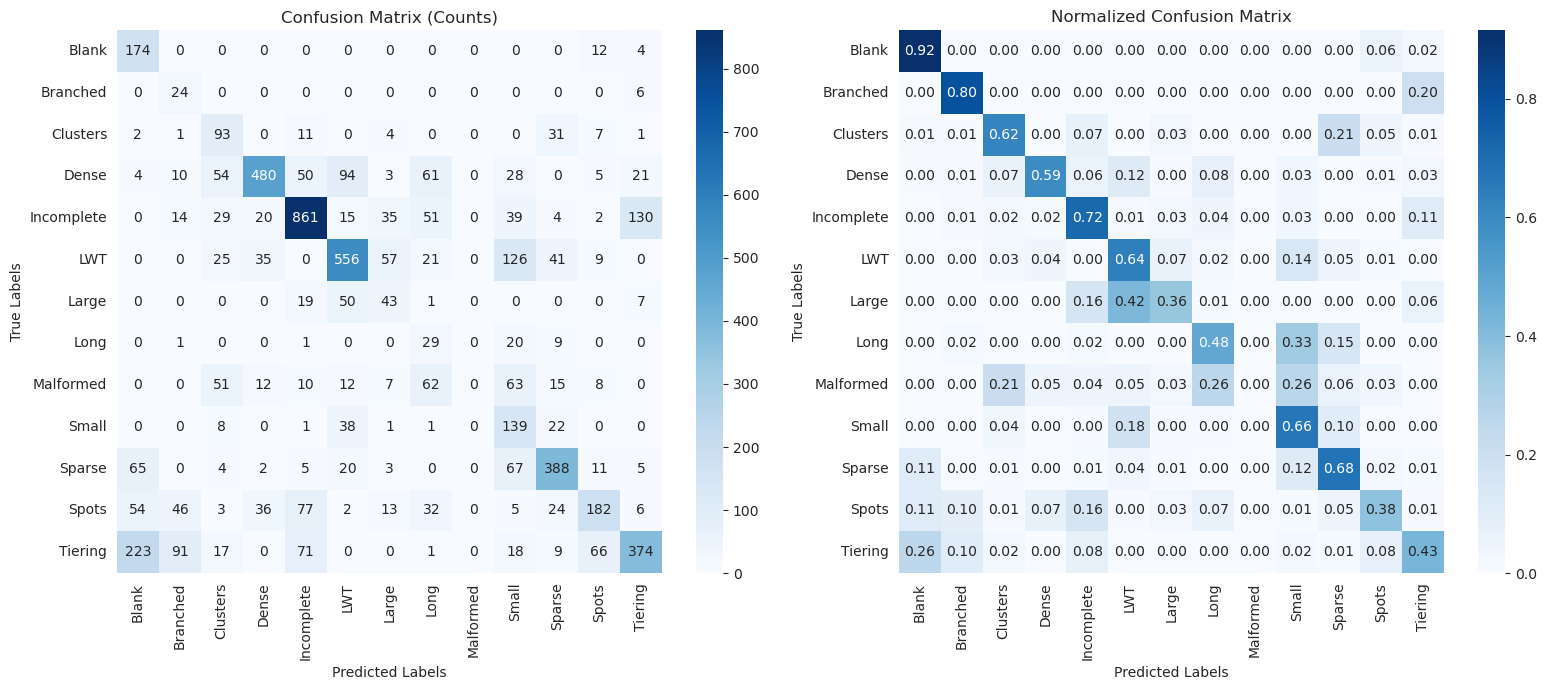

In [44]:
sorted_labels = sorted(label_dict, key=label_dict.get)
# Compute the confusion matrix
cm = confusion_matrix(true_labels_validation, pred_labels_validation)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

fig, ax = plt.subplots(ncols=2, figsize=(16, 7))  # Create a figure with two subplots

# Plot raw confusion matrix
sns.heatmap(cm, annot=True, fmt="d", cmap='Blues', ax=ax[0], xticklabels=sorted_labels, yticklabels=sorted_labels)
ax[0].set_title('Confusion Matrix (Counts)')
ax[0].set_xlabel('Predicted Labels')
ax[0].set_ylabel('True Labels')

# Plot normalized confusion matrix
sns.heatmap(cm_normalized, annot=True, fmt=".2f", cmap='Blues', ax=ax[1], xticklabels=sorted_labels,
            yticklabels=sorted_labels)
ax[1].set_title('Normalized Confusion Matrix')
ax[1].set_xlabel('Predicted Labels')
ax[1].set_ylabel('True Labels')

plt.tight_layout()
plt.savefig(f"{MODEL_DIR}/validation_confusion_matrix.png")

## If use uniform sampling

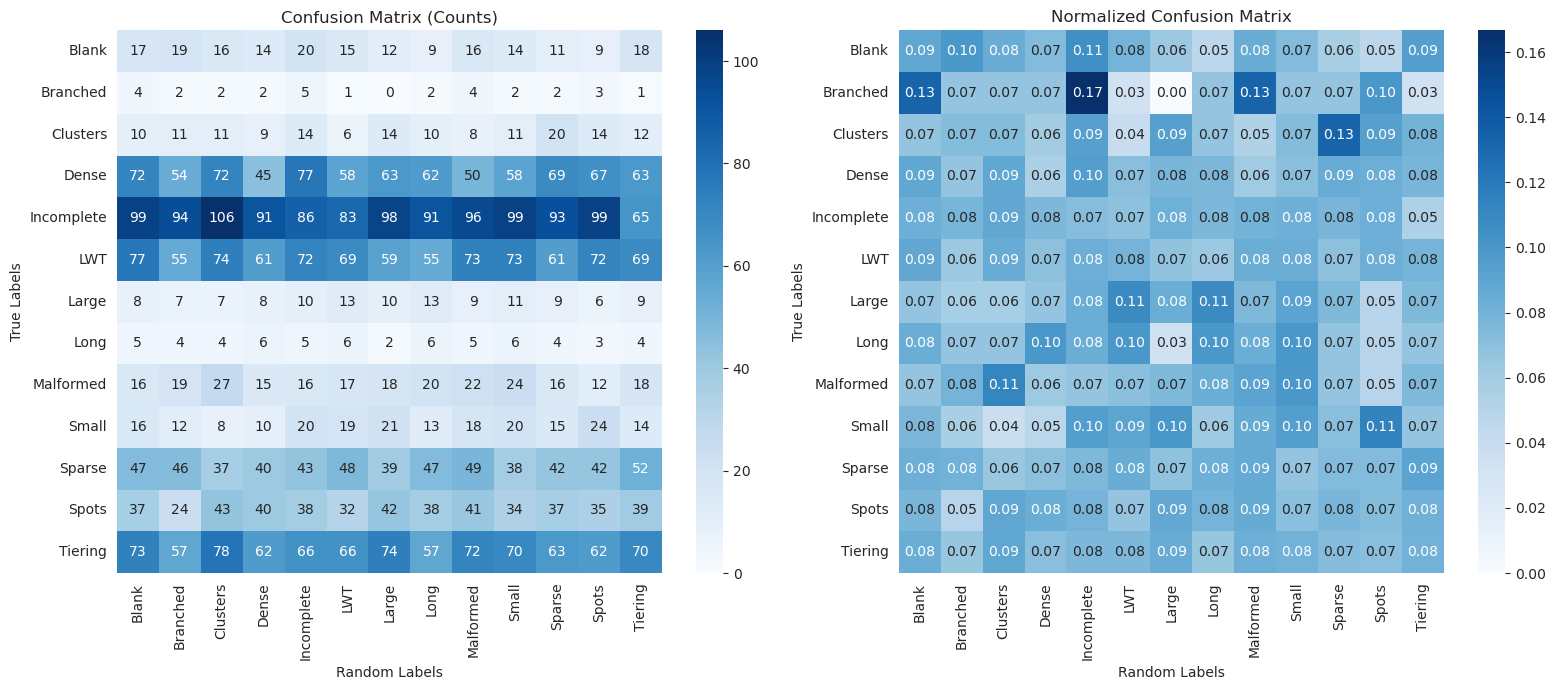

In [45]:
rand_labels_validation = np.random.randint(13, size=len(true_labels_validation))
sorted_labels = sorted(label_dict, key=label_dict.get)
# Compute the confusion matrix
cm = confusion_matrix(true_labels_validation, rand_labels_validation)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

fig, ax = plt.subplots(ncols=2, figsize=(16, 7))  # Create a figure with two subplots

# Plot raw confusion matrix
sns.heatmap(cm, annot=True, fmt="d", cmap='Blues', ax=ax[0], xticklabels=sorted_labels, yticklabels=sorted_labels)
ax[0].set_title('Confusion Matrix (Counts)')
ax[0].set_xlabel('Random Labels')
ax[0].set_ylabel('True Labels')

# Plot normalized confusion matrix
sns.heatmap(cm_normalized, annot=True, fmt=".2f", cmap='Blues', ax=ax[1], xticklabels=sorted_labels,
            yticklabels=sorted_labels)
ax[1].set_title('Normalized Confusion Matrix')
ax[1].set_xlabel('Random Labels')
ax[1].set_ylabel('True Labels')

plt.tight_layout()
plt.savefig(f"{MODEL_DIR}/validation_random_confusion_matrix.png")

In [46]:
validation_df

,run_id,scope_id,phenotype,name
0,223,39,Incomplete,Run0223_scope39-00_1081.jpg
1,223,39,Incomplete,Run0223_scope39-00_1441.jpg
2,223,39,Incomplete,Run0223_scope39-00_1241.jpg
3,224,42,Blank,Run0224_scope42-00_0001.jpg
4,224,42,Incomplete,Run0224_scope42-00_1081.jpg
...,...,...,...,...
575,763,10,Incomplete,Run0763_scope10-00_1081.jpg
576,763,10,Incomplete,Run0763_scope10-00_1241.jpg
577,765,17,Small,Run0765_scope17-00_1241.jpg
578,765,17,Small,Run0765_scope17-00_1081.jpg


## Training set

In [47]:
evaluation_dataset = ValidationDataset(training_df, copies=1, preload=False, method="center", dtype=MODEL_INPUT_DTYPE,
                                       normalize=MODEL_NORMALIZE, resize_by=MODEL_RESIZE_BY, norm_min=MODEL_NORM_MIN,
                                       norm_max=MODEL_NORM_MAX)
evaluation_loader = DataLoader(evaluation_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=VALIDATION_WORKERS)

true_labels = []
pred_labels = []

with torch.no_grad():
    for images, labels in evaluation_loader:
        images, labels = images.to(device), labels.to(device)

        outputs = detector(images)
        _, predicted = torch.max(outputs, 1)

        true_labels.extend(labels.cpu().numpy())
        pred_labels.extend(predicted.cpu().numpy())

true_labels_training = np.array(true_labels)
pred_labels_training = np.array(pred_labels)

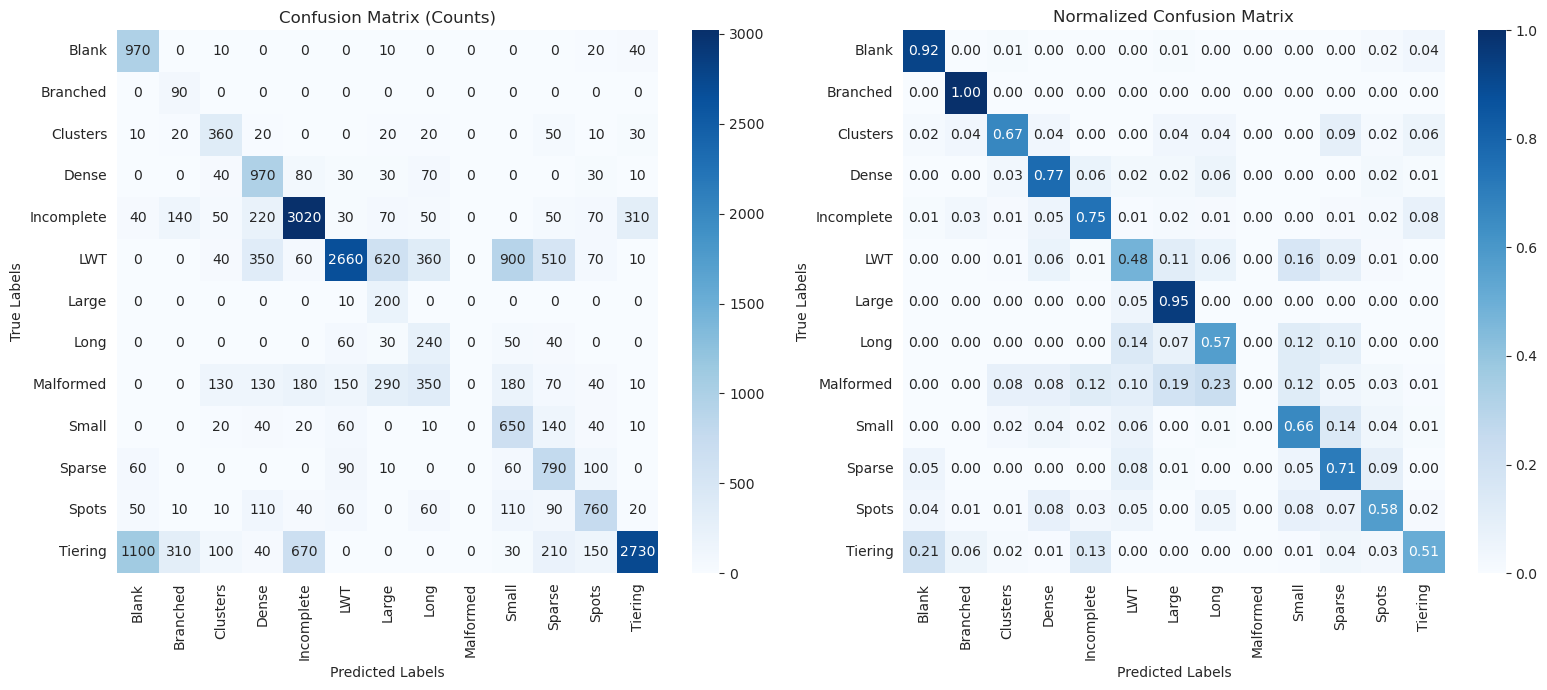

In [48]:
sorted_labels = sorted(label_dict, key=label_dict.get)
# Compute the confusion matrix
cm = confusion_matrix(true_labels_training, pred_labels_training)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

fig, ax = plt.subplots(ncols=2, figsize=(16, 7))  # Create a figure with two subplots

# Plot raw confusion matrix
sns.heatmap(cm, annot=True, fmt="d", cmap='Blues', ax=ax[0], xticklabels=sorted_labels, yticklabels=sorted_labels)
ax[0].set_title('Confusion Matrix (Counts)')
ax[0].set_xlabel('Predicted Labels')
ax[0].set_ylabel('True Labels')

# Plot normalized confusion matrix
sns.heatmap(cm_normalized, annot=True, fmt=".2f", cmap='Blues', ax=ax[1], xticklabels=sorted_labels,
            yticklabels=sorted_labels)
ax[1].set_title('Normalized Confusion Matrix')
ax[1].set_xlabel('Predicted Labels')
ax[1].set_ylabel('True Labels')

plt.tight_layout()
plt.savefig(f"{MODEL_DIR}/training_confusion_matrix.png")

# Visualize training curves

2024-05-29 21:07:30.830617: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2024-05-29 21:07:30.837519: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-05-29 21:07:30.841665: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.
2024-05-29 21:07:30.925414: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2024-05-29 21:07:30.926189: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 3800175000 Hz


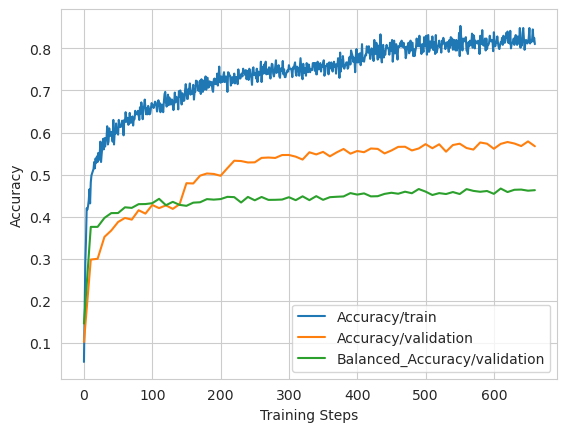

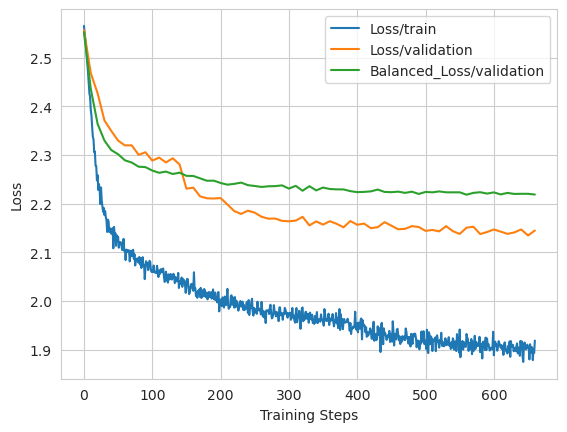

In [49]:
import tensorflow as tf
import matplotlib.pyplot as plt


def load_tensorboard_data(file_path, records):
    data = {record: [] for record in records}

    # Create an iterator over the stored events
    for e in tf.data.TFRecordDataset(file_path):
        event = tf.compat.v1.Event.FromString(e.numpy())
        for v in event.summary.value:
            if v.tag in data:
                try:
                    # metric_value = tf.make_ndarray(v.tensor).item()
                    data[v.tag].append((event.step, v.simple_value))
                except ValueError:
                    # Handle cases where conversion to a numpy ndarray is failing
                    print(f"Skipping a value at step {event.step} for tag {v.tag} due to conversion error.")

    return data


def plot_training_curves(data, xlabel='Training Steps', ylabel='Accuracy'):
    fig, ax = plt.subplots()
    for tag, values in data.items():
        if values:
            steps, metrics = zip(*values)
            ax.plot(steps, metrics, label=tag)

    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    # ax.set_title('Training Curves')
    ax.legend()
    plt.show()


# Change this path to the location of your TensorBoard log file
file_path = '/home/xavier/Documents/dataset/Welch/classification-v2024/classification_models/240430-001/events.out.tfevents.1714504231.xavier-desktop.6817.0'
data = load_tensorboard_data(file_path, ['Accuracy/train', 'Accuracy/validation', 'Balanced_Accuracy/validation'])
plot_training_curves(data)
file_path = '/home/xavier/Documents/dataset/Welch/classification-v2024/classification_models/240430-001/events.out.tfevents.1714504231.xavier-desktop.6817.0'
data = load_tensorboard_data(file_path, ['Loss/train', 'Loss/validation', 'Balanced_Loss/validation'])
plot_training_curves(data, ylabel="Loss")
